# 决策树

通过构造决策树来区分鸢尾花

## 须知概念

信息熵 -- 表示信息混乱程度，信息越杂乱，熵值越大，信息越有序，熵值越小  
信息增益 --  在某操作前后(比如这里的划分数据集，信息熵变化称为信息增益。若熵值减小，表示数据越有序。  
信息增益率 --  信息增益/影响的数据集的大小。表示变化率。

## Package

In [1]:
import numpy as np
from utils import calc_accuracy_class
from utils import fl_score
from utils import nomalize
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus 

import pandas as pd 

## 导入数据集

In [2]:
X,y = datasets.load_iris(return_X_y=True)
y = y.reshape(-1,1)

In [3]:
#将数据分为训练集和测试集
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size = 0.20,random_state = 1)
print(f"train_X的大小为：{train_X.shape}")
print(f"tain_y的大小为：{train_y.shape}")
print(f"test_X的大小为：{test_X.shape}")
print(f"test_y的大小为：{test_y.shape}")

train_X的大小为：(120, 4)
tain_y的大小为：(120, 1)
test_X的大小为：(30, 4)
test_y的大小为：(30, 1)


In [4]:
train_X[0:10]

array([[6.1, 3. , 4.6, 1.4],
       [7.7, 3. , 6.1, 2.3],
       [5.6, 2.5, 3.9, 1.1],
       [6.4, 2.8, 5.6, 2.1],
       [5.8, 2.8, 5.1, 2.4],
       [5.3, 3.7, 1.5, 0.2],
       [5.5, 2.3, 4. , 1.3],
       [5.2, 3.4, 1.4, 0.2],
       [6.5, 2.8, 4.6, 1.5],
       [6.7, 2.5, 5.8, 1.8]])

## 使用sklearn的库看看效果

In [5]:
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_X,train_y)
pred_y = tree_classifier.predict(train_X)
currect = np.sum(np.squeeze(pred_y) == np.squeeze(train_y))/train_y.shape[0]
print(f"训练集的准确率为:{currect}")
pred_y = tree_classifier.predict(test_X)
currect = np.sum(np.squeeze(pred_y) == np.squeeze(test_y))/test_y.shape[0]
print(f"测试集的准确率为:{currect}")

训练集的准确率为:1.0
测试集的准确率为:0.9666666666666667


In [6]:
dot_data = tree.export_graphviz(tree_classifier,out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("iris.pdf")

True

我们导出了树的pdf，如下所示:
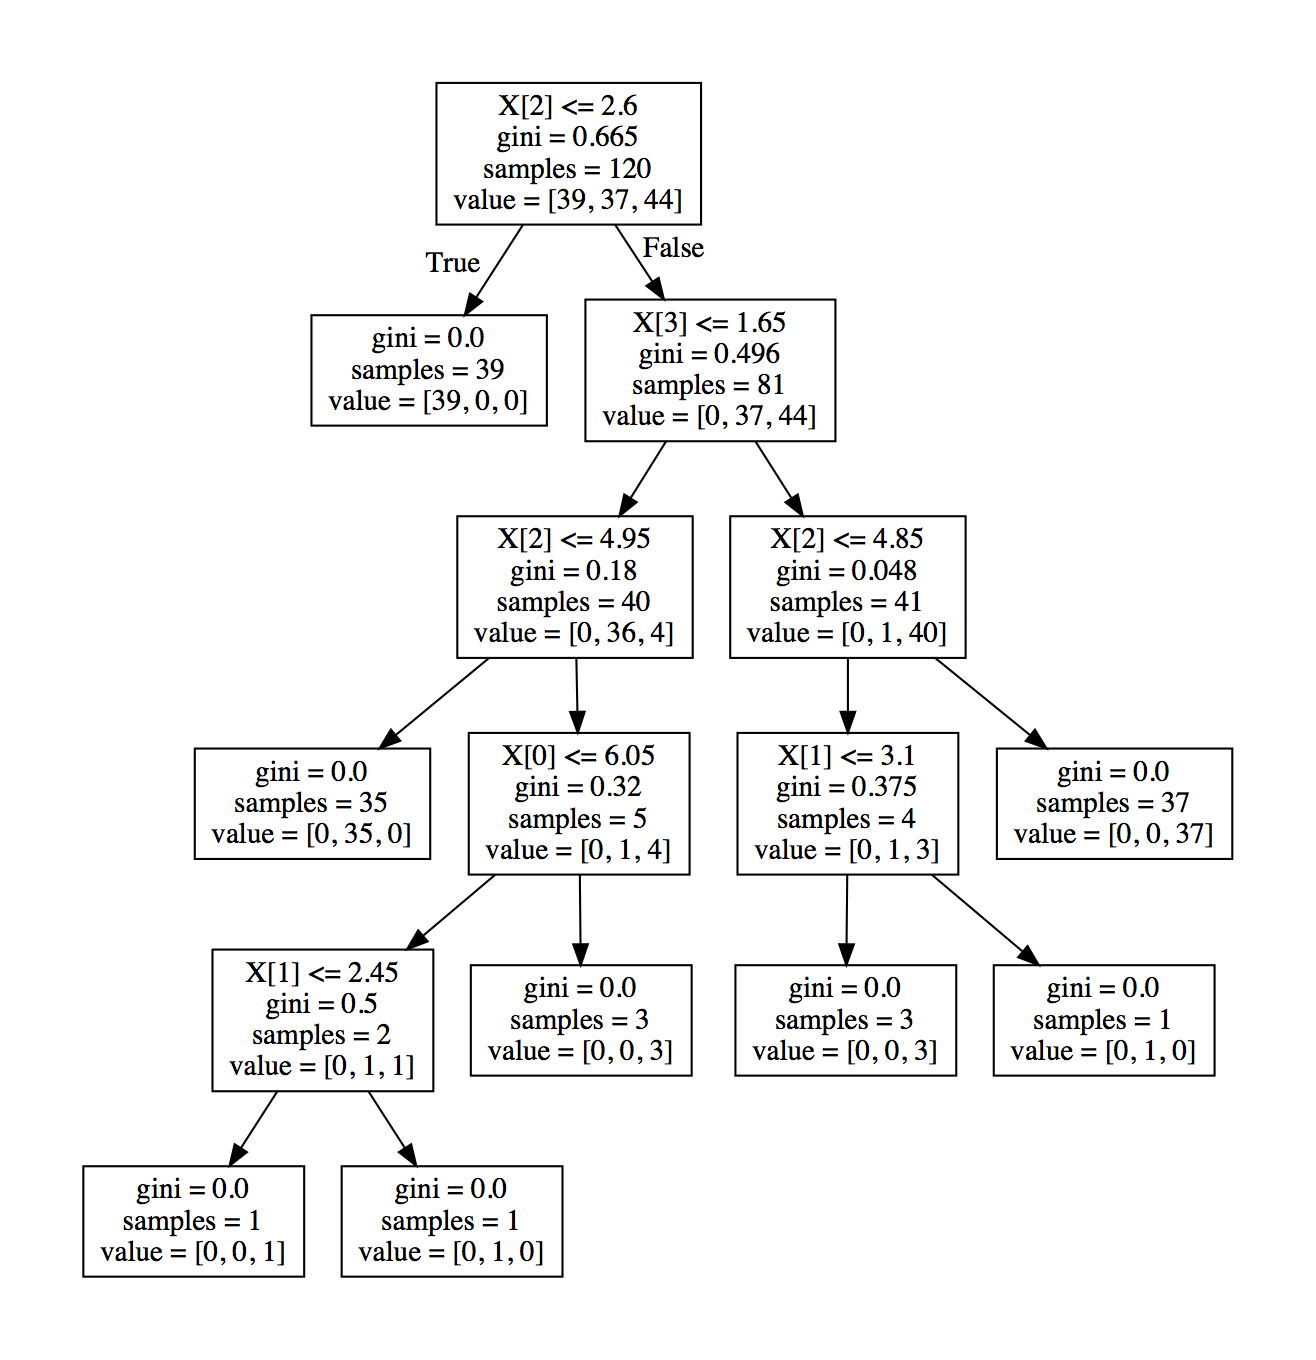

接下来，我们来自己实现一下

## 代码实现

### 信息熵计算

假设有K个分类，$P(k)$表示表示第k个分类的概率，$k\in {K}$。  
则信息熵为:
$H(K) = -\sum_{k\in{K}} P(k)log(P(k))$  
而根据大数定理，当数据达到一定量的时候，我们可以用频率来表示概率。  
所以可通过频率来算出P(k)

In [7]:
def compute_entropy(train_y):
    '''
    给定数据集，求出信息熵
    '''
    train_y = train_y.reshape(-1,)
    classes = set(train_y)
    m = train_y.shape[0]
    
    entropy = 0
    for c in classes:
        n_c = np.sum(train_y.reshape(-1,) == c)  #c类的个数
        p_c = n_c/m
        entropy = entropy - (p_c)*np.log(p_c)
    return entropy

### 根据最好的特征及分裂条件拆分数据集

我们的特征值是多个散列的浮点数集合，由sklearn库得出的树图可知，它将散列点按照某个值（均值或中间值等）划分为两列。  
这里我们使用均值划分

In [8]:
def split_data_set(X,y,feature_index):
    '''
    Function:
        根据分裂点及条件进行分裂
    Arguments:
        X -- shape is (m,n)
        y -- shape is (m,1)
        feature_Index -- 一个数值，表示特征的索引
    Return:
        ret_X --  一个list，包含分裂后的两组X数据
        ret_y --  一个list，包含分裂后的两组y数据
    '''
    m = X.shape[0]
    sub_features = X[:,feature_index]
    
#     temp = np.sort(sub_features) 
#     mid_idx = int(len(temp)/2)
#     mid_num =  temp[mid_idx]
#     con_value = mid_num
    
    con_value = np.sum(sub_features)/m #均值作为分裂点
        
    subset_index1 = np.where(sub_features <= con_value)
    subset_index2 = np.where(sub_features > con_value)
    
    subset_X1 = X[subset_index1]
    subset_X2 = X[subset_index2]
    
    subset_y1 = y[subset_index1]
    subset_y2 = y[subset_index2]
    
    return subset_X1,subset_X2,subset_y1,subset_y2,con_value
    
    

### 选取最好的特征进行分裂

当有N个特征的时候，如何选择分裂特征呢？  
选择信息熵下降最快的那个特征作为分裂特征。即信息增益或信息增益率最大的那个。  
两个所对应的算法分别为:IC3算法，C4.5算法

首先，我们是希望我们构建的决策树越矮越好，如果能够少几次分裂就能够分好类的，又何必多分几次呢  
所以，也就是分裂次数越少越好。要做到分裂次数越少越好，那就最好是每一次分裂都能够最大程度的将数据区分开来。  
这个最大区分开来的意思，就是每次分裂，每个子分类都越来越“纯”，即每个子分类的熵越低越好。  
那么基于此，最好的特征就是能够最快降低信息熵的那个。

In [123]:
def choose_best_feature(X,y):
    '''
    Function:
        选择最好的分裂特征
    Arguments:
        X -- shape is (m,n)
        y -- shape is (m,1)
    Return:
        best_feature_index -- 好分裂特征的索引值
        best_split_conval -- 分裂的条件值
    '''
    #先计算基础熵
    base_entorpy = compute_entropy(y)
    
    m,n_x = X.shape
    gain = 0
    best_feature_index = 0
    best_split_conval = 0
    for index in range(n_x):
        _,_,subset_y1,subset_y2,con_value = split_data_set(X,y,index)
        #计算两个的信息熵
        m1 =subset_y1.shape[0]
        m2  = subset_y2.shape[0]
        entropy1 = compute_entropy(subset_y1)
        entropy2 = compute_entropy(subset_y2)
        sum_entropy =(m1/m) *entropy1+(m2/m)*entropy2
        
        #计算信息增益
        sub_gain = base_entorpy-sum_entropy
        #print(f"{index}的信息增益为：{sub_gain}")
        
        if sub_gain > gain:
            gain = sub_gain
            best_feature_index = index
            best_split_conval = con_value
        
    #print(f"best gain is {gain},index is {best_feature_index}")
    return best_feature_index,best_split_conval


### 构建决策树

In [124]:
#生成一个子节点
def create_node(X,y,node_no,node_index,index, classes,cond_value=None,parent_cond_branch=None):
    '''
    Function:
        根据数据生成一个子节点
    Arguments:
        X -- 特征，shape is (m,n)
        y -- label，shape is (m,1)
        node_no -- json点编号，标识是第几层节点
        index -- 特征索引
        classes -- 分类类别
    Return:
        node -- a list of dict,include:
                            node_no -- 节点编号
                            index:特征索引
                            cond_value: 条件值 如 5.5 若不再分裂，则为None
                            parent_cond_branch --  父节点的条件分支  在这用0表示False分支，1 表示True分支。没有，则为None
                            samples -- 样本总数
                            values -- a list,记录每个分类的样本个数 ，如[47,49,58]
                          #  is_need_split -- 是否需要继续分裂  0：继续分裂; 1:停止分裂
     '''
    node = {}
    node["node_no"] = node_no
    node["node_index"] = node_index
    node["index"] = index
    node["cond_value"] = cond_value
    node["parent_cond_branch"] = parent_cond_branch
    node["samples"] = X.shape[0]
    values = []
    y_ = y.reshape(-1,)
    for sub_y in classes:
        count = np.sum(y_ == sub_y)
        values.append(count)
    
    node["values"] = values
    return node
    
    

In [125]:
def create_tree(node_list,classes,mytree):
    '''
    Function:
        构建决策树
    Arguments:
        node_list -- 节点列表，列表信息包含多个元组，每个元组有(X,y,node_no,parent_cond_branch)
        y -- label，shape is (m,1)
    Return:
        mytree -- a list of dict,include:
                            node_no -- 每一层的节点编号
                            node_index -- 节点层次索引
                            index:特征索引
                            cond_value: 条件值 如 5.5
                            parent_cond_branch --  父节点的条件分支  在这用0表示False分支，1 表示True分支
                            samples -- 样本总数
                            values -- a list,记录每个分类的样本个数 ，如[47,49,58]
    '''
    
    split_list = []
    sub_node_list = []
    for sub_node in  node_list:
        X,y,node_index,parent_cond_branch,node_no = sub_node
        # 如果只有一个类别，则不再分裂
        if len(set(y.reshape(-1,))) == 1 or (y.shape[0] < 5) :
            node = create_node(X,y,node_no,node_index,index = None,parent_cond_branch=parent_cond_branch,classes=classes)
            key = str(node_index)+"-"+str(node_no)
            mytree[key] = node
            continue
    
        best_feature_index,best_split_conval = choose_best_feature(X,y)
        node  =  create_node(X,y,node_no,node_index,best_feature_index,classes,cond_value=best_split_conval,parent_cond_branch=parent_cond_branch)
        key = str(node_index)+"-"+str(node_no)
        mytree[key] = node
        
        subset_X1,subset_X2,subset_y1,subset_y2,_ = split_data_set(X,y,best_feature_index)
        next_index = node_index+1
        #因为为二分裂，所以分裂的node_no为父node_no*2+parent_cond_branch
        split_list.append((subset_X1,subset_y1,next_index,0,node_no*2+0))
        split_list.append((subset_X2,subset_y2,next_index,1,node_no*2+1))


    if(len(split_list) > 0): 
        create_tree(split_list,classes,mytree)
        
    

### 训练

In [126]:
def fit(train_X,train_y):
    mytree = {}
    classes = set(np.squeeze(train_y))
    node_list = [(train_X,train_y,0,0,0)]
    create_tree(node_list,classes,mytree)
    return mytree,classes

In [127]:
mytree,classes = fit(train_X,train_y)
print(mytree)

{'0-0': {'node_no': 0, 'node_index': 0, 'index': 2, 'cond_value': 3.8100000000000005, 'parent_cond_branch': 0, 'samples': 120, 'values': [39, 37, 44]}, '1-0': {'node_no': 0, 'node_index': 1, 'index': 2, 'cond_value': 1.7804347826086957, 'parent_cond_branch': 0, 'samples': 46, 'values': [39, 7, 0]}, '1-1': {'node_no': 1, 'node_index': 1, 'index': 3, 'cond_value': 1.754054054054054, 'parent_cond_branch': 1, 'samples': 74, 'values': [0, 30, 44]}, '2-0': {'node_no': 0, 'node_index': 2, 'index': None, 'cond_value': None, 'parent_cond_branch': 0, 'samples': 38, 'values': [38, 0, 0]}, '2-1': {'node_no': 1, 'node_index': 2, 'index': 3, 'cond_value': 0.95, 'parent_cond_branch': 1, 'samples': 8, 'values': [1, 7, 0]}, '2-2': {'node_no': 2, 'node_index': 2, 'index': 3, 'cond_value': 1.3764705882352941, 'parent_cond_branch': 0, 'samples': 34, 'values': [0, 29, 5]}, '2-3': {'node_no': 3, 'node_index': 2, 'index': 1, 'cond_value': 3.0, 'parent_cond_branch': 1, 'samples': 40, 'values': [0, 1, 39]}, '3

### 预测

In [114]:
def node_judge(node,X,mytree):
    feature_indx = node["index"]
    node_no = node["node_no"]
    cond_value = node["cond_value"]
    node_index = node["node_index"]
    values = node["values"]
    if feature_indx == None: #表示已经到最后的节点，执行预测
        class_index = np.argmax(values)
        return class_index
    else:
        feature_X = X[feature_indx]
        next_node_index = node_index+1
        
        
        next_parent_cond_branch = 0
        if feature_X > cond_value:
            next_parent_cond_branch = 1
            
        next_key = str(next_node_index)+"-"+str(node_no*2+next_parent_cond_branch)
        next_node = mytree[next_key]
        return node_judge(next_node,X,mytree)
        

In [115]:
def predict(X,mytree,classes):
    root = mytree["0-0"] #第一个根节点
    pred_y = []
    classes = list(classes)
    for x in X:
        class_index = node_judge(root,x,mytree)
        pred_y.append(classes[class_index])
    return np.array(pred_y)
    

In [132]:
pred_y = predict(train_X,mytree,classes)
acc = calc_accuracy_class(pred_y.T,train_y)
print("训练集的正确率为:"+str(acc))

pred_y = predict(test_X,mytree,classes)
acc = calc_accuracy_class(pred_y.T,test_y)
print("测试集的正确率为:"+str(acc))



训练集的正确率为:0.9833333333333333
测试集的正确率为:0.9666666666666667
